## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR (pull request) to my repo. I will then revise and accept the PR, which will appear in my repo and be available to all the students in the course. This way, other students can learn from your creativity when transforming the variables in your dataset. 

### <font color='blue'>Student Results</font>
This was a fun exercise. Cumulative results of my efforts to reduce test rmse:<br>

- remove 1 GrLivArea outlier. Get error when remove second. Why??? ===> **44,459**
- add Total Area of house: basement sf + GrLivArea ===> **38,141**
- add Total Bathrooms ===> **37,805**
- add Has features ===> **36,784**
- smooth out OverallCond ===> **36,520**
- fix warnings in rare label encoder ===> **36,424**
- dummy for nbr hood StoneBr ===> **35,475**
- dummy for nbr hood NoRidge ===> **34,419**
- sum OverallQual and OverallCond ===> **33,361**
- removing second GrLivArea outlier, index 1298, it worked this time! ===> **30,210**
- removing outliers from Data rather than X_train and y_train ===> **27,735**
- remove outlier at index 30 ===> **26,473**  <font color='red'>**convergence warning**</font>
- remove outlier at index 88 ===> **26,256**  <font color='red'>**convergence warning**</font>
- remove outliers at index 88 and 462 ===> **23,833**  <font color='red'>**convergence warning**</font>
- remove outliers at both indexes 30 and 88 ===> <font color='red'>**Error!**</font>
- remove outliers 88, 462, 1322 ===> **23138**  <font color='red'>**convergence warning**</font>
- remove PoolArea from cat_encode_list ===> **22751** still has warning bc of outliers removed
- 
<br>

The results fit with what we would expect regarding real estate prices. People prefer larger houses, certain neighborhoods, more bathrooms, certain amenities like basement, pool etc. OverallCond was a little surprising however. It is poorly correlated with SalePrice and not monotonic but taking it out hurts the model. By using a map to smooth out the curve we were able to lower the rmse a little bit. 

## House Prices dataset

In [2]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler, RobustScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

In [3]:
# Student
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

### Load Datasets

In [4]:
# load dataset

data = pd.read_csv('../../data/house_prices/houseprice.csv')

In [5]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### <font color='blue'>Nothing I Tried With Restpect To Imputing Nulls Seemed To Help</font>


In [6]:
missing_val_col = [
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2']

# for i in missing_val_col:
#     data[i] = data[i].fillna('None')

Why does the below hurt the score??? If there is no BasementSF then there is no basement and the other fields should be NA. Seems like it anyway :)

In [7]:
# data.loc[data.TotalBsmtSF==0, missing_val_col] = 'NA'

### <font color='blue'>GrLivArea Outliers</font>
Outliers made a big difference but were tricky. Removing a row could blow up the model by causing it not to converge. It could also blow up the model by removing a rare label so there is no match in the train data to match a value in the test data. 

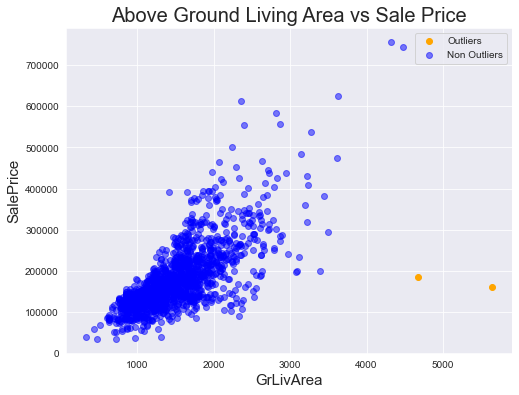

In [8]:
outs = data[(data.GrLivArea > 4000) & (data.SalePrice < 200000)]
non_outs = data[(data.GrLivArea < 4000) | (data.SalePrice > 200000)]

plt.figure(figsize=(8,6))
plt.scatter(x='GrLivArea', y='SalePrice', data=outs, label='Outliers', color='orange')
plt.scatter(x='GrLivArea', y='SalePrice', data=non_outs, label='Non Outliers', color='blue', alpha=0.5)
plt.legend()
plt.title('Above Ground Living Area vs Sale Price', fontsize=20)
plt.xlabel('GrLivArea', fontsize=15)
plt.ylabel('SalePrice', fontsize=15)
plt.show()

In [9]:
data.drop(outs.index, inplace=True)

### <font color='blue'>Other Outliers?</font>
There is a Kaggle Competition that uses this same dataset. In reading the notebooks of other solutions uploaded to Kaggle, I can see instances of people removing a list of outliers. They don't explain how they identified those outliers however. The outliers below are pulled from those lists.<br>

Thru trial and error was able to find 3 outliers I could remove without generating an error.

In [10]:
kaggle_kernals_1 = [88]
# data.drop(kaggle_kernals_1, inplace=True)

In [11]:
kaggle_kernals_2 = [462, 1322]
data.drop(kaggle_kernals_2, inplace=True)

### Separate train and test set

In [12]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

### <font color='blue'>Creating New Features</font>
Features that sum related values seemed to make a big difference. Especially total livable area in the house: basement + above ground living area. Interesting that adding OverallQual and OverallCond make a big difference over just having each separately in the feature list. Singling out 2 particular neighborhoods that seem to be different than the others seemed to make a big difference as well. Created dummy variables just for those 2 neighborhoods.<br>

Some things I tried didn't work. I left the code, just commented it out.

In [13]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)
    
# student
def total_area(df):
    df['TotalSF'] = (df['TotalBsmtSF'] 
                       + df['GrLivArea'])
    return df

X_train = total_area(X_train)
X_test = total_area(X_test)

# student
def qual_cond(df):
    df['QualCond'] = df.OverallQual + df.OverallCond
    return df

X_train = qual_cond(X_train)
X_test = qual_cond(X_test)

# student: doesn't help
# def porch_area(df):
#     df['PorchArea'] = (df['OpenPorchSF'] 
#                               + df['3SsnPorch'] 
#                               + df['EnclosedPorch'] 
#                               + df['ScreenPorch'] 
#                               + df['WoodDeckSF']
#                              )
#     return df

# X_train = porch_area(X_train)
# X_test = porch_area(X_test)

# student: doesn't help
# def outside_area(df):
#     df['Outside_Area'] = df.LotArea + df.PorchArea
#     return df

# X_train = outside_area(X_train)
# X_test = outside_area(X_test)

# student
def total_bathrooms(df):
    df['Total_Bathrooms'] = (df['FullBath'] 
                               + (0.5 * df['HalfBath']) 
                               + df['BsmtFullBath'] 
                               + (0.5 * df['BsmtHalfBath'])
                              )
    return df

X_train = total_bathrooms(X_train)
X_test = total_bathrooms(X_test)

# student
def add_has(df):
    df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return df

X_train = add_has(X_train)
X_test = add_has(X_test)

# student - doesn't help to single out the spike
# def oc_5(df):
#     df['OverallCond_5'] = np.where(df.OverallCond==5, 1, 0)
#     return df

# X_train = oc_5(X_train)
# X_test = oc_5(X_test)

# student
def compact_oc(df):
    df['OverallCond'] = np.where(df.OverallCond <= 5, 3, df.OverallCond)
    return df

X_train = compact_oc(X_train)
X_test = compact_oc(X_test)


# student: Doesnt help
# def get_garage_area(row):
#     if row.GarageCars == 0:
#         return 0
#     else:
#         return row.GarageArea / row.GarageCars

# X_train['Garage_Area_Per_Car'] = X_train.apply(get_garage_area, axis=1)
# X_test['Garage_Area_Per_Car'] = X_test.apply(get_garage_area, axis=1)

# Student: Neighborhood Features
# adding Crawfor actually weakens the model a little bit. But it really likes StoneBr and NoRidge
def nbr_hood(df):
    df['StoneBr'] = np.where(df.Neighborhood=='StoneBr', 1, 0)
    df['NoRidge'] = np.where(df.Neighborhood=='NoRidge', 1, 0)
#     df['Crawfor'] = np.where(df.Neighborhood=='Crawfor', 1, 0)
    return df

X_train = nbr_hood(X_train)
X_test = nbr_hood(X_test)

In [14]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [15]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

## Feature Engineering Pipeline

In [16]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

### <font color='blue'>Don't rare label encode anything with lt 4 categories</font>

In [17]:
cat_encode_list = categorical + discrete

# student: don't need poolarea in cat_encode_list
cat_encode_list.remove('PoolArea')
# cat_encode_list.remove('BedroomAbvGr')
# cat_encode_list.remove('TotRmsAbvGrd')

at_least_5 = [x for x in cat_encode_list if X_train[x].nunique() >= 5]
at_least_5.sort()

In [18]:
def fix_misc_feature(df):
    df['MiscFeature'] = np.where(df.MiscFeature.isnull(), 0, 1)
    return df

X_train = fix_misc_feature(X_train)
X_test = fix_misc_feature(X_test)

cat_encode_list.remove('MiscFeature')
categorical.remove('MiscFeature')

In [19]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind',
     mdi.AddMissingIndicator(
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    
    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.05,
                                    n_categories=4,
                                    variables=at_least_5)),
    ('categorical_enc',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=cat_encode_list)),
    
    
    # student: Gaussian Transformation - section 7 --> FAIL!!!
#     ('Boxcox transform',
#      vt.BoxCoxTransformer(variables = numerical_skewed)),

    # discretisation + encoding - section 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=5,
                                   return_object=True,
                                   variables=numerical)),
    ('encoding',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=numerical)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

### <font color='blue'>Rare Label NA Error In X_test</font>
Looking for category that exists in test data with no match in train data. This was helpful in identifying errors caused by removing outliers.

In [20]:
for c in cat_encode_list:
    test_set = set(X_test[c].value_counts().index)
    train_set = set(X_train[c].value_counts().index)
    
    if (test_set - train_set):
        print('error in',c)
        print(test_set - train_set)

In [21]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

C:\Users\cablu\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2237999745.218384, tolerance: 857596023.4361925
  positive)


In [22]:
# check model performance:
# student: turn into function
def display_results():
    print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
    print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
    print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
    print()
    print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
    print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
    print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
    
display_results()

train mse: 603896009.8875501
train rmse: 24574.29571498541
train r2: 0.9077533300839109

test mse: 517613739.39108276
test rmse: 22751.126112592377
test r2: 0.877092789715882


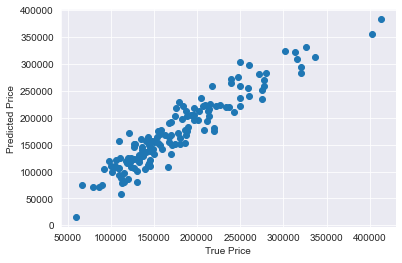

In [25]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price');

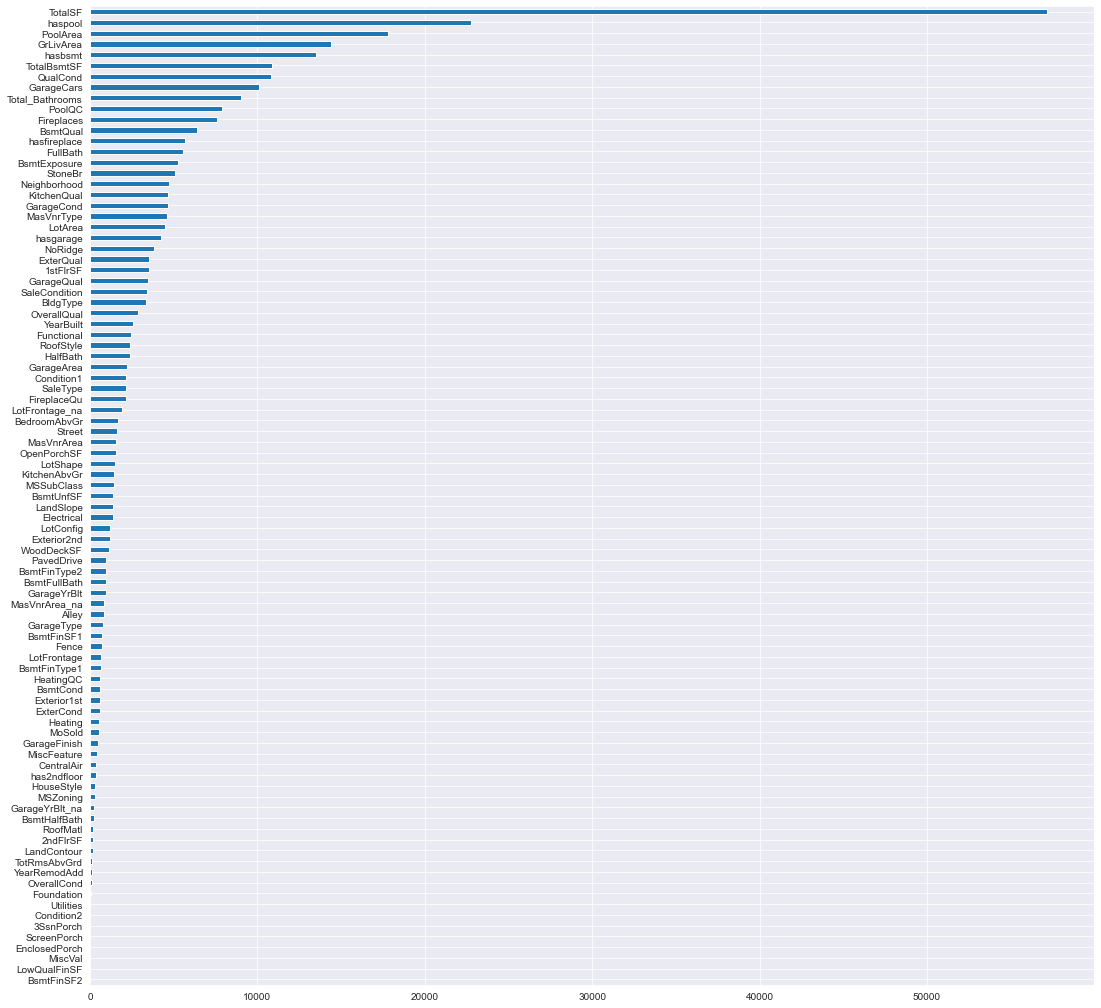

In [24]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True)
importance.plot.barh(figsize=(18,18));

### <font color='blue'>Student Conclusions</font>
Some surprising results in feature importances. So few houses in the data have a pool, yet it makes a big difference in the model. Not surprising that TotalSF is the most important feature. <br>

Overall it was a fun exercise and a great course. I would really be interested in a separate course like this focusing on outliers. That is the part that is the most mysterious to me at the moment.